In [1]:
from dnadb import dna, fasta, sample, taxonomy
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from pathlib import Path
import tensorflow as tf
import tf_utilities as tfu
import wandb

In [2]:
from deepdna.nn.models import load_model, setbert
from deepdna.nn.data_generators import SampleValueTargetGenerator

In [3]:
# tfu.devices.select_cpu()
tfu.devices.select_gpu(0)

2023-09-08 03:03:12.081764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 03:03:12.081976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 03:03:12.087434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 03:03:12.087646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 03:03:12.087814: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

([PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')],
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

---
## Dataset and Data Generators

First we need to load the metadata. We're interested in the oo_present field as we're detecting the presence of the fungus in the snake.

In [4]:
metadata = pd.read_csv("/home/shared/walker_lab/alex/230320_sfdspatial_meta_clean.csv", index_col=0)
metadata

,taxon,ecomode,oo_present,date,county,site,clinical_signs,log_copy_number,gpsn,gpsw,...,swab_col,DNA_con,swab_plate_n,notes,richness,shannon,evenness,simpson,invsimpson,dis.sev
swab_label,,,,,,,,,,,,,,,,,,,,,
STP582C,Agkistrodon piscivorus,Aquatic,0,6/7/2015,Polk,Ouachita National Forest,NaN,0.00000,34.46294,-93.99638,...,1.0,3.06,1.0,Walker et al. ISME,618,4.804865,0.197578,0.974111,38.627160,Neg
STP633C,Crotalus horridus,Terrestrial,0,6/8/2015,Polk,Ouachita National Forest,NaN,0.00000,34.46262,-93.99853,...,1.0,2.18,1.0,Walker et al. ISME,486,4.505452,0.186233,0.962531,26.688501,Neg
STP634C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Polk,Ouachita National Forest,NaN,0.00000,34.57593,-94.03164,...,1.0,40.80,1.0,Walker et al. ISME,456,2.743417,0.034079,0.723965,3.622725,Neg
STP639C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Montgomery,Ouachita National Forest,NaN,0.00000,34.43632,-93.78750,...,1.0,3.90,1.0,Walker et al. ISME,659,4.919205,0.207730,0.975840,41.391414,Neg
STP640C,Agkistrodon piscivorus,Aquatic,0,6/8/2015,Montgomery,Ouachita National Forest,NaN,0.00000,34.43632,-93.78750,...,1.0,6.14,1.0,Walker et al. ISME,384,4.312839,0.194407,0.963434,27.347450,Neg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STP1502C,Nerodia sipedon,Aquatic,1,NaN,Overton,Waterloo Falls,NaN,0.30103,NaN,NaN,...,11.0,22.60,2.0,Walker et al. ISME,692,4.422581,0.120392,0.959926,24.954109,Low
STP1503C,Nerodia sipedon,Aquatic,1,NaN,Overton,Waterloo Falls,NaN,0.30103,NaN,NaN,...,11.0,22.60,2.0,Walker et al. ISME,823,5.162691,0.212192,0.980217,50.549217,Low
STP762C,Thamnophis sirtalis,Terrestrial,1,NaN,Cumberland,Catoosa WMA,NaN,1.00000,NaN,NaN,...,2.0,23.20,1.0,Walker et al. ISME - Austin Property-Crossville,739,4.925323,0.186379,0.979888,49.721213,Low


Next we'll load all of the samples, removing any where metadata is not present.

In [5]:
samples = sample.load_multiplexed_fasta("/tmp/sfd.fasta.db", "/tmp/sfd.fasta.mapping.db")
samples = [s for s in samples if s.name in metadata.index] # remove samples without metadata
len(samples)

737

Then we'll create a dictionary mapping each sample's name with its corresponding oo_present flag

In [6]:
targets = {sample_name: row["oo_present"] for sample_name, row in metadata.iterrows()}

Finally we create data generators for the model.

In [7]:
train_data = SampleValueTargetGenerator(
    samples=samples,
    sample_values=targets,
    sequence_length=150,
    kmer=3,
    subsample_size=1000,
    batch_size=4,
    batches_per_epoch=100
)

validation_data = SampleValueTargetGenerator(
    samples=samples,
    sample_values=targets,
    sequence_length=150,
    kmer=3,
    subsample_size=1000,
    batch_size=4,
    batches_per_epoch=20
)

Grab a batch from the training data generator

In [8]:
sequences, labels = train_data[0]

In [9]:
sequences.shape

(4, 1000, 148)

In [10]:
sequences

array([[[58, 42, 41, ..., 40, 34, 10],
        [15, 60, 51, ..., 51, 13, 52],
        [33,  7, 31, ..., 42, 42, 40],
        ...,
        [30, 56, 33, ..., 14, 58, 42],
        [45, 55, 30, ..., 43, 44, 50],
        [31, 62, 59, ..., 58, 41, 38]],

       [[27, 47, 63, ..., 37, 20, 16],
        [10, 41, 38, ...,  2, 10, 41],
        [48,  2, 11, ..., 30, 58, 40],
        ...,
        [ 8, 34, 10, ..., 43, 46, 59],
        [16,  2,  9, ..., 11, 46, 56],
        [26, 40, 35, ..., 50,  8, 34]],

       [[46, 59, 44, ..., 41, 38, 24],
        [ 0,  2,  8, ..., 33,  6, 25],
        [48,  0,  2, ..., 56, 33,  6],
        ...,
        [39, 29, 52, ..., 17,  6, 24],
        [15, 62, 58, ..., 49,  7, 31],
        [ 6, 27, 44, ..., 41, 38, 24]],

       [[62, 59, 44, ..., 41, 38, 24],
        [63, 62, 59, ..., 43, 45, 55],
        [25, 38, 27, ..., 30, 58, 42],
        ...,
        [40, 32,  3, ...,  8, 35, 12],
        [47, 63, 62, ..., 41, 37, 21],
        [60, 48,  3, ..., 14, 57, 38]]], dtyp

In [11]:
labels.shape

(4,)

In [12]:
labels

array([1., 0., 1., 0.], dtype=float32)

## Load a Pre-trained Model

In [13]:
api = wandb.Api()

In [14]:
# path = api.artifact("sirdavidludwig/setbert-pretrain/setbert-pretrain-walker-abund-128d-250l:v3").download()
# pretrained_setbert = load_model(path).base

path = "./logs/models/setbert_taxonomy_naive"
pretrained_setbert = load_model(path).base.base

2023-09-08 03:03:16.603859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-08 03:03:16.606173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 03:03:16.606403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-08 03:03:16.606568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [15]:
pretrained_setbert

## Create a Predictor Model

Since the base SetBERT model is just a stack of transformers, we need to fetch only the class token from the output so that we have a single output summarizing the entire sample. This is achieved by wrapping the pretrained base SetBERT model with `SetBertEncoderModel`.

In [16]:
encoder = setbert.SetBertEncoderModel(pretrained_setbert, compute_sequence_embeddings=True)

Because the encoder will need to embed all of the sequences, we need to make sure we specify a chunk size so that it only processes a certain number of sequences at a time so that we do not run out of memory.

In [17]:
encoder.chunk_size = 256

In [18]:
encoder(sequences)

2023-09-08 03:03:54.577933: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<tf.Tensor: shape=(4, 64), dtype=float32, numpy=
array([[-18.81169   , -25.19563   ,  -0.15179968,  -2.2167826 ,
          3.0202935 ,  -3.1814103 , -11.886603  ,  -2.2135344 ,
         26.29296   ,   4.587865  ,   7.240786  , -20.821342  ,
         12.450818  , -20.292656  ,  -1.7710929 ,  18.343336  ,
        -14.949516  ,   4.2376156 ,  19.629473  , -12.796109  ,
         10.95548   ,  -5.643384  ,   8.280922  ,   9.098734  ,
         -3.4624014 ,  13.562147  , -33.110153  ,   2.254669  ,
        -10.180323  ,  -1.6492329 ,  14.835     ,  -7.359783  ,
         19.017002  ,  13.291755  , -14.175228  ,  23.225056  ,
         12.748436  ,  -7.688333  , -11.956315  ,  23.17669   ,
          8.95434   , -18.61464   ,  24.316778  , -16.623415  ,
          9.457305  ,  -6.365667  , -12.421804  , -10.01412   ,
          7.4583526 ,  20.190289  ,   8.348947  , -28.172504  ,
          0.84661293, -17.361956  , -27.311045  ,   7.061784  ,
         12.881136  ,  10.030384  ,  10.945988  ,  -6.6

In [19]:
x = encoder.input
y = encoder.output
y = tf.keras.layers.Dense(1, activation="sigmoid", name="OO_Present")(y)
model = tf.keras.Model(x, y)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=tf.keras.metrics.BinaryAccuracy()
)

In [20]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1000, 148)]       0         
                                                                 
 chunked_embedding_layer_1 (  (None, 1000, None)       1210496   
 ChunkedEmbeddingLayer)                                          
                                                                 
 set_bert_model (SetBertMode  (None, 1001, 64)         2340672   
 l)                                                              
                                                                 
 split_class_token_2 (SplitC  ((None, 64),             0         
 lassToken)                   (None, 1000, 64))                  
                                                                 
 OO_Present (Dense)          (None, 1)                 65        
                                                           

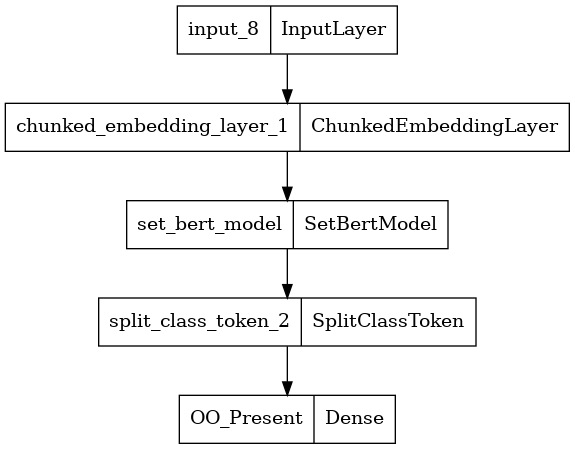

In [21]:
tf.keras.utils.plot_model(model, to_file="/tmp/model.png")

## Training the Model

In [ ]:
history = model.fit(train_data, validation_data=validation_data)